In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
from dataclasses import dataclass, field

## Hyperparameters
evaluating 10 quantiles, using 60% data for training, 15% for validation and the rest for testing<br>
the remaining hyperparameters are tuned based on performance<br>
<br>
filename: file name for the data<br>
beststate: file name to save the best model, inputed after entering config<br>
logdir: folder to store logged info (must end with "/"), enter empty string to store in the same folder as this file<br>
lagperiod: no. of period used for input (no. of hours in this case)<br>
forecast: forecast horizon (no. of hours ahead)<br>
numfeatures: no. of assets in the data, inputed after loading data <br>
hidden: no. of hidden units for Convolutional LSTM<br>
batch:batch size <br>
lr: learning rate <br>
output: no. of outputs, 1 prediction+ 10 quantiles = 11 for this case, inputed after loading data


In [2]:
#Config Parameters
@dataclass
class Args:
    filename:str = "/Users/lixiang/Desktop/DeepJMQR Project/crypto_data.csv"
    beststate:str = None
    logdir:str = "./logs/"
    quantiles:list = field(default_factory = lambda:[0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
    trainfrac:float = 0.6
    valfrac:float = 0.15
    lagperiod:int = 60
    forecast:int = 2
    numfeatures:int = None
    hidden:int = 200
    batch:int = 64
    lr:float = 0.00002
    output:int = None
    dropout:float = 0.1
    epochs:int = 50

## Load Data
crypto_data.csv compiles all 9 crypto data on the repo

first column (date) is excluded 

data is split into inputs (X) and labels(Y)

In [3]:
#Load & Split Data
def get_data(args):
    data = np.array(pd.read_csv(args.filename))[:,1:].astype("float32")
    alldata = np.array([data[i+1]/data[i]-1 for i in range(len(data)-1)])
    torch.set_default_dtype(torch.float32)
    X = torch.tensor(np.array([alldata[i-args.lagperiod:i] for i in range(args.lagperiod, len(alldata))]))
    Y = alldata[args.lagperiod+args.forecast:]
    return X,Y

## Split Data
data is split into train, validation and testing sets using dataloader

In [4]:
def get_loader(X,Y,args):
    i_train = int(len(Y)*args.trainfrac)
    i_val = int(len(Y)*(args.valfrac+args.trainfrac))
    end = len(Y)
    train_iter = torch.utils.data.DataLoader(list(zip(X[:i_train],torch.tensor(Y[:i_train]))), batch_size=args.batch, shuffle = True)
    val_iter = torch.utils.data.DataLoader(list(zip(X[i_train:i_val],Y[i_train:i_val])), batch_size=args.batch, shuffle = False)
    test_iter = torch.utils.data.DataLoader(list(zip(X[i_val:end],Y[i_val:end])), batch_size=args.batch, shuffle = False)
    return train_iter, val_iter, test_iter, i_train, i_val

## Evaluation & Loss Functions
The functions below are defined such that they could be used in both MLP and ConvLSTM implementations.
For the inputs to these functions, they are defined as follows:
1. $\hat{y}$: prediction with shape (sample size)  x (outputs = 1 mean + 10 quantiles) x (no. of features = 9)
2. $y$: observation with shape (sample size) x (no. of features = 9)
3. $\tau$: quantile vector of length (J=10)

$y$ and $\hat{y}$ are tensors for loss function and numpy array for evaluation functions.
<br>


### Loss Function
As defined in the paper, the loss function is the sum of mean squared errors and tilted loss. The for loop computes the 2nd summation.

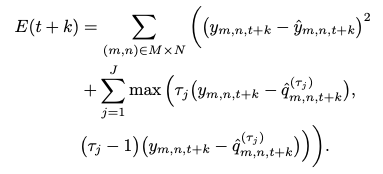

In [5]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.mean(torch.square(y-ŷ[:,0,:]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += torch.mean(q*r - r*(r<0))
    return loss

### Tilted Loss
Similar to the 2nd summation in loss function. Tilted loss is evaluated on quantiles only which is why the 2nd index (i+1) ranges from 1 to 10 for $\hat{y}$.

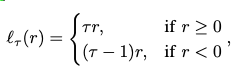

In [6]:
#for evaluation: remember to turn tensors into np.array()
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += np.mean(q*r - r*(r<0))
    return loss

### Crossing Loss & Number of Crosses
Crossing loss and number of crosses are evaluated on neighbouring quantiles only which is why we have the 2nd indices of (i+1) and (i+2) (same reason as tilted loss) and for loop range of (11-2=9) for 10 quantiles.
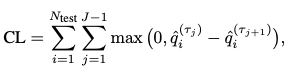

In [7]:
def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(ŷ.shape[1]-2):
        q = ŷ[:,i+1,:] - ŷ[:,i+2,:]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
    loss /= ŷ.shape[0]*(ŷ.shape[1]-2)
    num_cross /= ŷ.shape[0]
    return loss, num_cross

### Interval Coverage Percentage (ICP) & Mean Interval Length (MIL)
ICP: the fraction of observations (y) that are within the prediction interval
<br>MIL: the average length of the prediction interval
<br> (lower , upper) is the corresponding pair of predicted quantiles e.g. 5% and 95% quantiles, 10% and 90% quanatiles etc

In [8]:
def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

### Errors (MSE, RMSE, MAE)
Standard error functions evaluated on predicted means only. Therefore, the 2nd index for $\hat{y}$ is 0

correct_sign computes the fraction of predictions that gets the sign correctly

In [9]:
def eval_error(y, ŷ):
    r = np.abs(y-ŷ[:,0,:])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    correct_sign = np.mean(y*ŷ[:,0,:]<0)/(1-np.mean(y*ŷ[:,0,:]==0))
    return mse, rmse, mae, correct_sign

### Checking Quantiles
1. determines the quality of quantiles (mainly for 40% and 60% quantiles)
2. determines % of time where we will execute trades
3. determines % of trades executed that are profitable

In [10]:
def check_quantiles(y,ŷ,i_low,i_high):
    numfeatures = y.shape[1]
    #1. accuracy of quantiles
    print("1. Fraction of")
    print("true return > 40% quantile:",f'{np.mean(y > ŷ[:,i_low,:]):.10f}')
    print("true return < 60% quantile:",f'{np.mean(y < ŷ[:,i_high,:]):.10f}')
    #2. volume of trades
    print("2. Fraction of")
    print("40% quantiles > 0:",f'{np.mean(ŷ[:,i_low,:]>0):.10f}')
    print("60% quantiles < 0:",f'{np.mean(ŷ[:,i_high,:]<0):.10f}')
    #3. profitability
    print("3. Probability of")
    print("true return > 0 given 40% quantile > 0:", f'{np.mean([[ŷ[i,i_low,j]>0 and y[i,j]>0 for i in range(len(y))] for j in range(numfeatures)])/np.mean(ŷ[:,i_low,:]>0):.10f}')
    print("true return < 0 given 60% quantile < 0:", f'{np.mean([[ŷ[i,i_high,j]<0 and y[i,j]<0 for i in range(len(y))] for j in range(numfeatures)])/np.mean(ŷ[:,i_high,:]<0):.10f}')

evaluates errors

In [11]:
def eval(y,ŷ, model, quantiles):
    closs, num_cross = crossing_loss(ŷ)
    tloss = tilted_loss(quantiles, y, ŷ)
    mse, rmse, mae, correct_sign = eval_error(y, ŷ)
    icp, mil = [], []
    for i in range(len(quantiles)//2):
        t1,t2 = eval_quantiles(ŷ[:,i+1,:],ŷ[:,len(quantiles)-i,:],y)
        icp.append(f'{t1:.6f}')
        mil.append(f'{t2:.6f}')
    return f'{closs:.10f}', f'{num_cross:.10f}', f'{tloss:.10f}', f'{mse:.10f}', f'{rmse:.10f}', f'{mae:.10f}', f'{correct_sign*100:.6f}', icp, mil

print errors

In [12]:
def print_error(closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil, quantiles):
    performance = [closs, num_cross, tloss, mse, rmse, mae, correct_sign]
    predinterval = [[round((quantiles[len(quantiles)-i-1]-quantiles[i])*100) for i in range(len(quantiles)//2)], icp, mil]
    print("Crossing Loss:", closs, ", Number of Crosses:", num_cross)
    print("MSE:",mse, "RMSE:", rmse,"MAE:", mae)
    print("Tilted loss:", tloss)
    print("Prediction Intervals:")
    for i in range(len(quantiles)//2):
        print("{}% ICP:{}, MIL:{}".format(round((quantiles[len(quantiles)-i-1]-quantiles[i])*100),icp[i],mil[i]))
    print("the model predicts the sign correctly in ", correct_sign,"% of the cases (excluding 0)")
    return performance, predinterval

## Model Initialization
batch normalization is used as the 1st layer as to obtain the same scale for different assets

dropout is used after Convolutional LSTM

the final output layer is equivalent to a 1x1 linear convolutional layer according to DeepJMQR's author

default parameter initialization is used
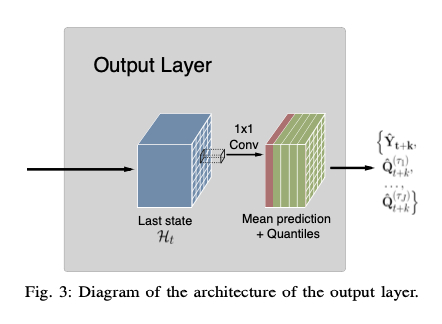

In [13]:
#Initialize Model
def make_model(args):
    net = nn.Sequential(nn.BatchNorm1d(args.lagperiod, affine = False),
                        nn.Flatten(), 
                        nn.Linear(args.lagperiod*args.numfeatures,args.hidden),     
                        nn.ReLU(),                    
                        nn.Dropout(args.dropout),
                        nn.Linear(args.hidden,args.hidden//2),
                        nn.ReLU(),
                        nn.Linear(args.hidden//2,args.output*args.numfeatures),
                        nn.Unflatten(1,(args.output, args.numfeatures)))
    return net

### Training & Validation
inputs data in batches into the model to make predictions, evaluates loss value and makes adjustment to parameters (when training), then returns average loss value across batches

the same function is reused for both training & validation

Reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

"The Training Loop" & "Per-Epoch Activity"

In [14]:
#Train & Val Model
def one_epoch(model, one_iter, quantiles, optimizer = None):
    running_loss = 0.0
    for i, data in enumerate(one_iter):
        inputs, labels = data
        outputs = model(inputs)
        loss = lossfn(quantiles, labels, outputs)
        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
        last_loss = loss.item()
    return running_loss / (i+1)

## Main Training Function
trains the model, visualizes training and validation loss, saves the best performing model

In [15]:
def train(X,Y,args):
    train_iter, val_iter, test_iter, i_train, i_val = get_loader(X,Y,args)
    model = make_model(args)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = args.lr)
    animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,args.epochs], legend = ["train", "val"])
    best_vloss = 1e9
    trainlogs = []
    for i in range(args.epochs):
        running_loss = 0.0
        model.train(True)
        avg_loss = one_epoch(model, train_iter, args.quantiles, optimizer=optimizer)
        model.eval()
        running_vloss = 0.0
        avg_vloss = one_epoch(model, val_iter, args.quantiles)
        if i % (args.epochs//10) == args.epochs//10-1:
            trainlogs.append([i+1, f'{avg_loss:.10f}', f'{avg_vloss:.10f}'])
        animator.add(i+1, (avg_loss, avg_vloss))
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model, args.beststate)
    model = torch.load(args.beststate)
    return model, trainlogs, i_train, i_val

### Log Training & Performance Info
logs training & validation loss, performance (crossing & tilted loss, RMSE, no. of crosses etc), prediction intervals (ICP & MIL)

In [16]:
def log(args, tlogs, performance, predinterval):
    tlogs.columns = ["epoch", "train loss", "valid loss"]
    performance.columns = ["Crossing Loss", "No. of Crosses", "Tilted Loss", "MSE", "RMSE", "MAE", "Correct Sign (%)"]
    predinterval.columns = ["Prediction Interval(%)", "ICP", "MIL"]
    tlogs.to_csv(args.logdir+"MLP_trainlogs_{}_{}_{}_{}.csv".format(args.lagperiod, args.forecast, args.hidden, args.epochs))
    performance.to_csv(args.logdir+"MLP_performance_{}_{}_{}_{}.csv".format(args.lagperiod, args.forecast, args.hidden, args.epochs))
    predinterval.to_csv(args.logdir+"MLP_prediction_interval_{}_{}_{}_{}.csv".format(args.lagperiod, args.forecast, args.hidden, args.epochs))

## Main Body

In [17]:
def explore(args):
    X,Y = get_data(args)
    args.numfeatures = Y.shape[1]
    args.output = len(args.quantiles)+1
    args.beststate = "model_best_state_MLP_{}_{}_{}_{}".format(args.lagperiod, args.forecast, args.hidden, args.epochs)
    model, tlogs, i_train, i_val = train(X,Y,args)
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil = eval(Y_val, pred, model, args.quantiles)
    performance, predinterval = print_error(closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil, args.quantiles)
    log(args,pd.DataFrame(tlogs), pd.DataFrame(performance).transpose(), pd.DataFrame(predinterval).transpose())
    print()
    q40index = args.quantiles.index(0.4)+1
    q60index = args.quantiles.index(0.6)+1
    check_quantiles(Y_val, pred,q40index, q60index)

### Visualization
plots predicted 40% & 60% quantiles and true returns

plots everything in validation set by default

input asset with values from 0 to 8 to view the quantile performance for all 9 assets

In [18]:
def visualize(args, asset = 0, start = None, end = None):
    q40index = args.quantiles.index(0.4)+1
    q60index = args.quantiles.index(0.6)+1
    model = torch.load(args.beststate)
    X,Y = get_data(args)
    i_train = int(len(Y)*args.trainfrac)
    i_val = int(len(Y)*(args.valfrac+args.trainfrac))
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    s = asset
    if start == None:
        start = 0
    if end == None:
        end = len(Y_val)
    df = pd.DataFrame(np.vstack((Y_val[start:end,s],pred[start:end,q40index,s],pred[start:end,q60index,s])).transpose(), columns = ["trues","40%","60%"])
    df.plot(lw=0.5)

Crossing Loss: 0.0009673582 , Number of Crosses: 6.2156219232
MSE: 0.0001147551 RMSE: 0.0107123824 MAE: 0.0073262202
Tilted loss: 0.0248876447
Prediction Intervals:
90% ICP:0.903840, MIL:0.033649
80% ICP:0.803121, MIL:0.022552
60% ICP:0.605404, MIL:0.013350
40% ICP:0.383182, MIL:0.007634
20% ICP:0.181891, MIL:0.003564
the model predicts the sign correctly in  49.858440 % of the cases (excluding 0)

1. Fraction of
true return > 40% quantile: 0.6055865514
true return < 60% quantile: 0.5733873026
2. Fraction of
40% quantiles > 0: 0.1410130183
60% quantiles < 0: 0.2313021916
3. Probability of
true return > 0 given 40% quantile > 0: 0.5050426687
true return < 0 given 60% quantile < 0: 0.4962951285


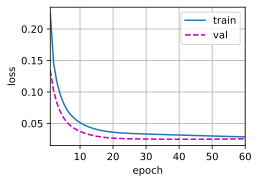

In [19]:
args = Args(lagperiod = 60, forecast = 2, hidden = 200, epochs = 60)
explore(args)

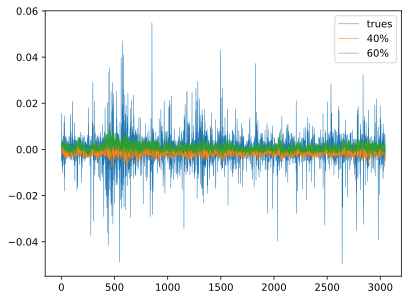

In [20]:
visualize(args, asset = 3)